##**Data Preprocessing & Transformation**

##### Mount G Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/5008 Project

/content/drive/.shortcut-targets-by-id/1bBIjKsvs3fOfhtXtLG83N0fVmT-uhzTl/5008 Project


##### Import Packages:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Raw Data Cleaning:**

In [ ]:
# Import Raw Datasets:
df1 = pd.read_csv('./Raw_Data/airports.csv', encoding = 'unicode_escape', keep_default_na = False) # source: https://ourairports.com/data/
df2 = pd.read_csv('./Raw_Data/runways.csv', keep_default_na = False) # source: https://ourairports.com/data/
df3 = pd.read_csv('./Raw_Data/routes.csv', keep_default_na = False) # source: https://www.kaggle.com/datasets/open-flights/flight-route-database?resource=download

In [ ]:
#### Airports Cleaning:
df1.drop(columns=['scheduled_service', 'gps_code', 'local_code', 'home_link', 'wikipedia_link', 'keywords'], inplace=True)
df1.rename(columns={'id': 'airport_id', 'ident': 'airport_ref'}, inplace=True)

# Filter where airport has IATA code:
df1 = df1[df1.iata_code.notnull()]

# Rename Seaports as Small Airports and Filter dataset for Airports only:
df1['type'].replace('seaplane_base', 'small_airport', inplace=True)
df1['type'].replace('heliport', 'small_airport', inplace=True)
df1['type'].replace('balloonport', 'small_airport', inplace=True)

# replace null elevation with 0. As per the data; sea level airports are logged as null:
df1['elevation_ft'] = df1['elevation_ft'].fillna('0') #, inplace=True)
#df1['elevation_ft'] = pd.to_numeric(df1['elevation_ft'])

# Binary attribute fields for nominal feature:
#from pandas.core.reshape.reshape import get_dummies
temp = pd.get_dummies(pd.Series(df1['type']))
df1 = pd.concat([df1, temp], axis=1)

df1 = df1.reindex(columns=['airport_id','airport_ref','iata_code','name',
                           'type','small_airport','medium_airport','large_airport',
                           'latitude_deg','longitude_deg','elevation_ft',
                           'continent','iso_country','iso_region','municipality'])

airports = df1
#airports.head()

In [ ]:
#### Runways Cleaning:
df2.drop(columns=['le_ident', 'le_latitude_deg','le_longitude_deg','le_elevation_ft',
                  'le_heading_degT','le_displaced_threshold_ft','he_ident',
                  'he_latitude_deg','he_longitude_deg','he_elevation_ft',
                  'he_heading_degT','he_displaced_threshold_ft'], inplace=True)
df2.rename(columns={'id': 'runway_id',
                    'airport_ref': 'airport_id',
                    'airport_ident': 'airport_ref'}, inplace=True)
# Filter for active runways only:
df2 = df2[df2.closed == 0]

runways = df2
runways.head()

,runway_id,airport_id,airport_ref,length_ft,width_ft,surface,lighted,closed
0,232758,6402,TNCA,9000,148,ASP,1,0
1,232759,6359,TAPA,9003,148,ASP,1,0
2,232760,5232,OMAR,3438,72,MAC,1,0
3,232761,5228,OMAH,8205,148,ASP,0,0
4,232762,5236,OMDM,12970,148,ASP,1,0


In [ ]:
#runways.loc[runways['airport_id'] == 348158]

In [ ]:
#### Merge Airports & Aggregated Runway Data:

df4 = pd.merge(airports, runways, how='left', on=['airport_id','airport_ref'])
df4 = df4.groupby(['airport_id','airport_ref','iata_code','name','type','small_airport','medium_airport','large_airport',
                   'latitude_deg','longitude_deg','elevation_ft','continent','iso_country','iso_region','municipality'], dropna=False)['runway_id'].nunique().reset_index()
df4.rename(columns={'runway_id': 'num_runways'}, inplace=True)

airport_runways = df4
airport_runways.head()

,airport_id,airport_ref,iata_code,name,type,small_airport,medium_airport,large_airport,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,num_runways
0,2,OM11,,Abu Dhabi Northeast Airport - Suweihan Air Base,small_airport,1,0,0,24.526793,54.974812,88,AS,AE,AE-AZ,Abu Dhabi,1
1,3,AGGH,HIR,Honiara International Airport,large_airport,0,0,1,-9.428000,160.054993,28,OC,SB,SB-GU,Honiara,1
2,4,AGGM,MUA,Munda Airport,medium_airport,0,1,0,-8.327970,157.263000,10,OC,SB,SB-WE,Munda,1
3,5,AL-LA10,,GjirokastÃ«r Airfield,small_airport,1,0,0,40.085383,20.153890,666,EU,AL,AL-05,GjirokastÃ«r,1
4,7,UD21,,Arzni Airport,small_airport,1,0,0,40.294102,44.564602,4416,AS,AM,AM-KT,Nor Hachn,2


In [ ]:
#### Routes Cleaning:
df3.drop(columns=[' codeshare', ' stops'], inplace=True)
df3.rename(columns={'airline ID': 'airline_id',
                    ' source airport id': 'source_airport_id',
                    ' source airport': 'source_airport_iata',
                    ' destination airport id': 'destination_airport_id',
                    ' destination apirport': 'destination_airport_iata',
                    ' equipment': 'equipment'}, inplace=True)

# replace missing airport keys (will need a value when transforming to graph data):
df3.loc[df3['source_airport_id'] == r'\N', 'source_airport_id'] = df3['source_airport_iata']
df3.loc[df3['destination_airport_id'] == r'\N', 'destination_airport_id'] = df3['destination_airport_iata']

routes = df3
routes.head()

,airline,airline_id,source_airport_iata,source_airport_id,destination_airport_iata,destination_airport_id,equipment
0,2B,410,AER,2965,KZN,2990,CR2
1,2B,410,ASF,2966,KZN,2990,CR2
2,2B,410,ASF,2966,MRV,2962,CR2
3,2B,410,CEK,2968,KZN,2990,CR2
4,2B,410,CEK,2968,OVB,4078,CR2


In [ ]:
# Export Transformed Datasets:
airports.to_csv('./Transformed_Data/airports.csv', index = False)
runways.to_csv('./Transformed_Data/runways.csv', index = False)
routes.to_csv('./Transformed_Data/routes.csv', index = False)
airport_runways.to_csv('./Transformed_Data/airport_runways.csv', index = False)

## **Transform for Vizualisation Input**

In [ ]:
# Source & Destination Attributes:

df7 = pd.merge(routes, airports, left_on='source_airport_iata', right_on='iata_code', how='left')
df7.drop(columns=['airport_id','airport_ref','iata_code','small_airport','medium_airport','large_airport','iso_region','municipality'], inplace=True)
df7.rename(columns={'name': 'src_ap_name', 'type': 'src_ap_type', 'latitude_deg': 'src_ap_lat', 'longitude_deg': 'src_ap_lon','elevation_ft':'src_ap_elev', 'continent':'src_ap_continent', 'iso_country':'src_ap_country'}, inplace=True)
#df7.columns
df7 = pd.merge(df7, airports, left_on='destination_airport_iata', right_on='iata_code', how='left')
df7.drop(columns=['airport_id','airport_ref','iata_code','small_airport','medium_airport','large_airport','iso_region','municipality'], inplace=True)
df7.rename(columns={'name': 'des_ap_name', 'type': 'des_ap_type', 'latitude_deg': 'des_ap_lat', 'longitude_deg': 'des_ap_lon','elevation_ft':'des_ap_elev', 'continent':'des_ap_continent', 'iso_country':'des_ap_country'}, inplace=True)
df7.columns

src_des_info = df7

src_des_info.head()

,airline,airline_id,source_airport_iata,source_airport_id,destination_airport_iata,destination_airport_id,equipment,src_ap_name,src_ap_type,src_ap_lat,...,src_ap_elev,src_ap_continent,src_ap_country,des_ap_name,des_ap_type,des_ap_lat,des_ap_lon,des_ap_elev,des_ap_continent,des_ap_country
0,2B,410,AER,2965,KZN,2990,CR2,Sochi International Airport,large_airport,43.449902,...,89,EU,RU,Kazan International Airport,large_airport,55.606201,49.278702,411,EU,RU
1,2B,410,ASF,2966,KZN,2990,CR2,Astrakhan Narimanovo Boris M. Kustodiev Intern...,medium_airport,46.282843,...,-65,AS,RU,Kazan International Airport,large_airport,55.606201,49.278702,411,EU,RU
2,2B,410,ASF,2966,MRV,2962,CR2,Astrakhan Narimanovo Boris M. Kustodiev Intern...,medium_airport,46.282843,...,-65,AS,RU,Mineralnyye Vody Airport,medium_airport,44.225101,43.081902,1054,EU,RU
3,2B,410,CEK,2968,KZN,2990,CR2,Chelyabinsk Balandino Airport,medium_airport,55.305801,...,769,EU,RU,Kazan International Airport,large_airport,55.606201,49.278702,411,EU,RU
4,2B,410,CEK,2968,OVB,4078,CR2,Chelyabinsk Balandino Airport,medium_airport,55.305801,...,769,EU,RU,Novosibirsk Tolmachevo Airport,large_airport,55.019756,82.618675,365,EU,RU


In [ ]:
# Export the Routes with Source & Destination airport info:
src_des_info.to_csv('./Transformed_Data/src_des_info.csv')

## **Transform to Graph Input:**

In [ ]:
#### Create Dictionary for Airport Node Matrix:
df5 = routes.copy()

airport_key = list(df5['source_airport_id'].unique())
for i in list(df5['destination_airport_id'].unique()):
  if i not in airport_key:
    airport_key.append(i)

airport_dict = {}
for id, i in enumerate(airport_key):
  airport_dict[i] = id

df5['src_ap_id'] = df5['source_airport_id'].map(airport_dict)
df5['des_ap_id'] = df5['destination_airport_id'].map(airport_dict)

df5.drop(columns=['source_airport_id', 'destination_airport_id'], inplace=True)
df5.rename(columns={'source_airport_id': 'src_ap_id', 'destination_airport_id': 'des_ap_id'}, inplace=True)

route_key = df5
route_key.head()

,airline,airline_id,source_airport_iata,destination_airport_iata,equipment,src_ap_id,des_ap_id
0,2B,410,AER,KZN,CR2,0,7
1,2B,410,ASF,KZN,CR2,1,7
2,2B,410,ASF,MRV,CR2,1,9
3,2B,410,CEK,KZN,CR2,2,7
4,2B,410,CEK,OVB,CR2,2,13


In [ ]:
#route_key.to_csv('./Transformed_Data/route_key.csv', index = False)

In [ ]:
df6 = pd.merge(routes, airport_runways, left_on='source_airport_iata', right_on='iata_code', how='left')
df6 = df6.merge(route_key, on=['airline','airline_id','source_airport_iata','destination_airport_iata','equipment'], how='left')
df6.drop(columns='iata_code', inplace=True)

route_key_attributes = df6

route_key_attributes.head()

,airline,airline_id,source_airport_iata,source_airport_id,destination_airport_iata,destination_airport_id,equipment,airport_id,airport_ref,name,...,large_airport,latitude_deg,longitude_deg,elevation_ft,iso_country,iso_region,municipality,num_runways,src_ap_id,des_ap_id
0,2B,410,AER,2965,KZN,2990,CR2,6519,URSS,Sochi International Airport,...,1,43.449902,39.956600,89,RU,RU-KDA,Sochi,2,0,7
1,2B,410,ASF,2966,KZN,2990,CR2,6520,URWA,Astrakhan Narimanovo Boris M. Kustodiev Intern...,...,0,46.282843,48.010511,-65,RU,RU-AST,Astrakhan,2,1,7
2,2B,410,ASF,2966,MRV,2962,CR2,6520,URWA,Astrakhan Narimanovo Boris M. Kustodiev Intern...,...,0,46.282843,48.010511,-65,RU,RU-AST,Astrakhan,2,1,9
3,2B,410,CEK,2968,KZN,2990,CR2,26370,USCC,Chelyabinsk Balandino Airport,...,0,55.305801,61.503300,769,RU,RU-CHE,Chelyabinsk,1,2,7
4,2B,410,CEK,2968,OVB,4078,CR2,26370,USCC,Chelyabinsk Balandino Airport,...,0,55.305801,61.503300,769,RU,RU-CHE,Chelyabinsk,1,2,13


In [ ]:
# Export the Routes mapped to keys, with attributes:
route_key_attributes.to_csv('./Transformed_Data/route_key_attributes.csv')

## **EDA:**

<Figure size 1000x600 with 0 Axes>

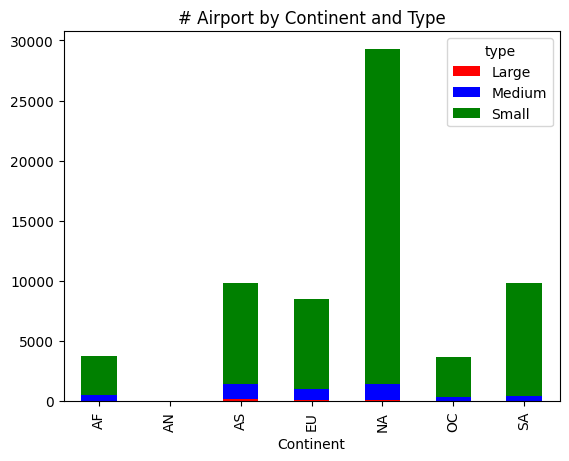

In [ ]:
airports.columns
airports = airports[airports.type != 'closed']

# Count unique airports for each iso_region and type
iata_code_continent = airports.groupby(['continent', 'type'])['iata_code'].count().unstack()

colors = {'Large': 'red', 'Medium': 'blue', 'Small': 'green'}

iata_code_continent = iata_code_continent.rename(columns={'large_airport': 'Large', 
                                                          'medium_airport': 'Medium',
                                                          'small_airport': 'Small'})

plt.figure(figsize=(10,6))
iata_code_continent.plot(kind='bar', stacked=True, color=[colors[c] for c in iata_code_continent.columns])
plt.xlabel('Continent')
plt.title('# Airport by Continent and Type')
plt.show()

In [4]:
df = pd.read_csv('./Transformed_Data/route_key_attributes.csv', index_col = 0)
df.columns

Index(['airline', 'airline_id', 'source_airport_iata', 'source_airport_id',
       'destination_airport_iata', 'destination_airport_id', 'equipment',
       'airport_id', 'airport_ref', 'name', 'type', 'small_airport',
       'medium_airport', 'large_airport', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'iso_country', 'iso_region', 'municipality',
       'num_runways', 'src_ap_id', 'des_ap_id'],
      dtype='object')

In [ ]:
# Count the total unique union of 'source_airport_aita' and 'destination_airport_aita'
unique_airports = df['source_airport_iata'].append(df['destination_airport_iata']).nunique()
# Count the number of unique combinations of 'source_airport_aita' and 'destination_airport_aita'
unique_routes = df.groupby(['source_airport_iata', 'destination_airport_iata']).size().count()
# Count the total number of combinations of 'source_airport_aita' and 'destination_airport_aita'
total_routes = df.groupby(['source_airport_iata', 'destination_airport_iata']).size().sum()

print("Total unique airports: ", unique_airports)
print("Total unique airport combinations: ", unique_routes)
print("Total airport combinations: ", total_routes)

Total unique airports:  3425
Total unique airport combinations:  37595
Total airport combinations:  67719


<ipython-input-17-488be3e8ae90>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique_airports = df['source_airport_iata'].append(df['destination_airport_iata']).nunique()


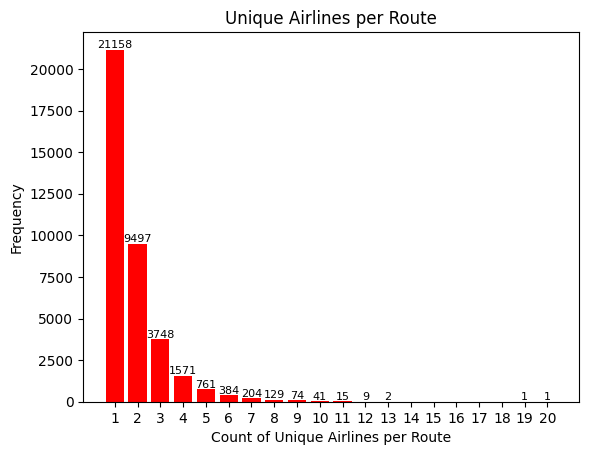

In [119]:
# Count the number of times each unique pair of 'source_airport_iata', 'destination_airport_iata', and 'airline' occurs
airline_counts = (df[['source_airport_iata', 'destination_airport_iata', 'airline']]
          .groupby(['source_airport_iata', 'destination_airport_iata'])
          .nunique()['airline']
          .reset_index(name='count'))

# Create the bar chart
labels, counts = np.unique(airline_counts['count'], return_counts=True)
plt.bar(labels, counts, color='red')

# Set the x-tick labels as integers
plt.gca().set_xticks(np.arange(labels[0], labels[-1]+1))

for i in range(len(labels)):
    plt.text(labels[i], counts[i]+100, counts[i], ha='center', fontsize='8')

# Set the labels and title
plt.xlabel('Count of Unique Airlines per Route')
plt.ylabel('Frequency')
plt.title('Unique Airlines per Route')

plt.show()

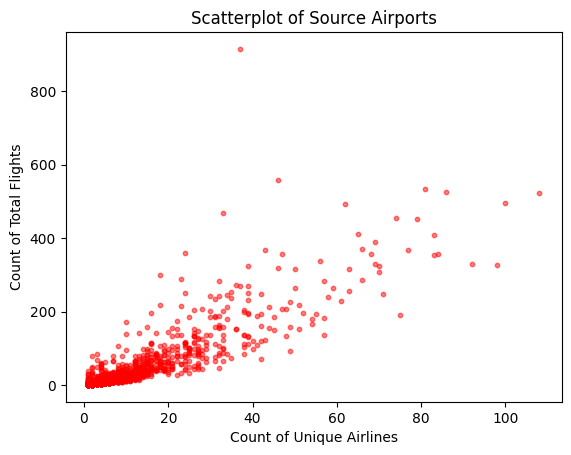

In [ ]:
# calculate the counts
counts = df.groupby(['source_airport_iata']).agg({'airline': 'nunique', 'destination_airport_iata': 'count'}).reset_index()
counts.rename(columns={'airline': 'unique_airlines_count', 'destination_airport_iata': 'total_flights_count'}, inplace=True)

# plot the scatterplot
plt.scatter(x=counts['unique_airlines_count'], y=counts['total_flights_count'], s=10, alpha=0.5, color='red')

# add labels and title
plt.xlabel('Count of Unique Airlines')
plt.ylabel('Count of Total Flights')
plt.title('Scatterplot of Source Airports')

# show the plot
plt.show()

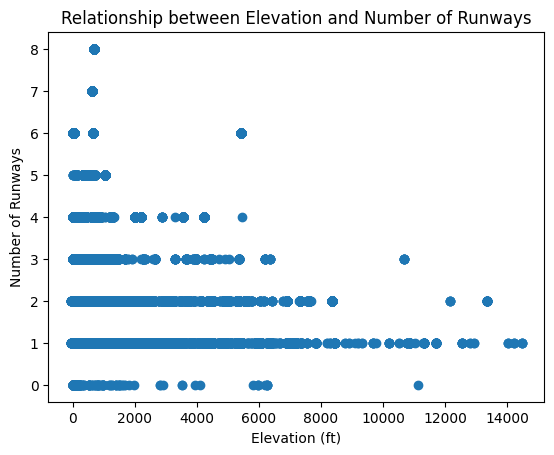

In [ ]:
# Create a scatter plot of elevation_ft and num_runways
plt.scatter(df['elevation_ft'], df['num_runways'])
plt.xlabel('Elevation (ft)')
plt.ylabel('Number of Runways')
plt.title('Relationship between Elevation and Number of Runways')
plt.show()

In [ ]:
df.head()

,airline,airline_id,source_airport_iata,source_airport_id,destination_airport_iata,destination_airport_id,equipment,airport_id,airport_ref,name,...,large_airport,latitude_deg,longitude_deg,elevation_ft,iso_country,iso_region,municipality,num_runways,src_ap_id,des_ap_id
0,2B,410,AER,2965,KZN,2990,CR2,6519,URSS,Sochi International Airport,...,1,43.449902,39.956600,89,RU,RU-KDA,Sochi,2,0,7
1,2B,410,ASF,2966,KZN,2990,CR2,6520,URWA,Astrakhan Narimanovo Boris M. Kustodiev Intern...,...,0,46.282843,48.010511,-65,RU,RU-AST,Astrakhan,2,1,7
2,2B,410,ASF,2966,MRV,2962,CR2,6520,URWA,Astrakhan Narimanovo Boris M. Kustodiev Intern...,...,0,46.282843,48.010511,-65,RU,RU-AST,Astrakhan,2,1,9
3,2B,410,CEK,2968,KZN,2990,CR2,26370,USCC,Chelyabinsk Balandino Airport,...,0,55.305801,61.503300,769,RU,RU-CHE,Chelyabinsk,1,2,7
4,2B,410,CEK,2968,OVB,4078,CR2,26370,USCC,Chelyabinsk Balandino Airport,...,0,55.305801,61.503300,769,RU,RU-CHE,Chelyabinsk,1,2,13


In [ ]:
# Create a stacked bar chart of the mean num_runways for each combination of airline, type, and iso_region, broken down by source_airport_aita and destination_airport_aita
grouped[['source_airport_aita', 'destination_airport_aita']].plot(kind='bar', stacked=True)
plt.xlabel('Airline, Type, and ISO Region')
plt.ylabel('Mean Number of Runways')

plt.title('Mean Number of Runways for Each Combination of Airline, Type, and ISO Region, by Source and Destination Airport')
plt.show()